# Ransomware Communication Analysis: Linguistic Patterns & Financial Tiers
**FYP Data Analysis PHASE 1 Work**

## Overview
For PHASE 1 of our paper and to establish some ground work, this notebook processes text data from ransomware ransom notes to analyze linguistic patterns—specifically "Service" (helpfulness) and "Aggression" (threats). It correlates these lexical density scores with external financial data (estimated ransom demands) to identify strategic differences between elite (Tier 1) and amateur (Tier 3) cybercriminal groups.

## Methodology
1. **Ingestion**: Reads raw `.txt` ransom notes and loads financial statistics from `.csv`.
2. **Lexical Analysis**: Calculates density scores based on predefined keyword dictionaries.
3. **Data Aggregation**: Groups data by ransomware family and merges with financial tiers.
4. **Visualization**: Generates three key charts to illustrate market positioning and professionalism gaps.

In [2]:
# --- 1. CONFIGURATION & SETUP ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style for the charts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Paths
NOTES_FOLDER = 'ransom_notes_dataset/'  # Folder containing your .txt files
STATS_FILE = 'ransom_stats.csv'         # File containing the financial data


In [3]:
# --- 2. DEFINITIONS ---

# A. Keyword Dictionaries for Scoring
service_keywords = [
    'guarantee', 'support', 'help', 'decrypt', 'customer', 'service', 
    'reputation', 'honest', 'assist', 'chat', 'ticket', 'free', 'trial', 
    'post-paid', 'welcome', 'team', 'contact'
]

aggression_keywords = [
    'destroy', 'leak', 'publish', 'media', 'fail', 'dead', 'stupid', 
    'regret', 'warn', 'attack', 'delete', 'lost', 'forever', 'shame',
    'criminal', 'police', 'fbi'
]

# B. Mapping Dictionary
group_mapping = {
    # TIER 1 (Elite)
    'alphv': ['alphv', 'blackcat'],
    'lockbit': ['lockbit'],
    'conti': ['conti'],
    'revil': ['revil', 'sodinokibi'],
    'darkside': ['darkside'],
    'clop': ['clop'],
    'blackbasta': ['blackbasta'],
    'hive': ['hive'],
    'royal': ['royal'],
    'blackmatter': ['blackmatter'],
    'ransomhub': ['ransomhub'],
    'darkangels': ['darkangels'],
    'inc': ['inc'],
    'ryuk': ['ryuk'],
    'doppelpaymer': ['doppelpaymer'],
    'cuba': ['cuba'],

    # TIER 2 (Mid-Market)
    'dharma': ['dharma'],
    'phobos': ['phobos'],
    'avaddon': ['avaddon'],
    'play': ['play'],
    'akira': ['akira'],
    'blackbyte': ['blackbyte'],
    'bianlian': ['bianlian'],
    'medusa': ['medusa'],
    'rhysida': ['rhysida'],
    'knight': ['knight'],
    'cactus': ['cactus'],
    'netwalker': ['netwalker'],

    # TIER 3 (Amateur/Mass Market)
    'gandcrab': ['gandcrab'],
    'cerber': ['cerber'],
    'wannacry': ['wannacry', 'wcry'],
    'teslacrypt': ['teslacrypt'],
    'locky': ['locky'],
    'makop': ['makop'],
    'maze': ['maze'],
    'snatch': ['snatch'],
    'stop': ['stop'],
    'nemty': ['nemty'],
    'qlocker': ['qlocker'],
    'xorist': ['xorist'],
    'magniber': ['magniber'],
    'globeimposter': ['globeimposter'],
}


In [4]:
# --- 3. FUNCTIONS ---

def analyze_note(text):
    """
    Calculates Service and Aggression scores using Lexical Density.
    Returns normalized score per 100 words.
    """
    text_lower = text.lower()
    
    # 1. Count Keywords
    service_count = sum(text_lower.count(word) for word in service_keywords)
    aggression_count = sum(text_lower.count(word) for word in aggression_keywords)
    
    # 2. Normalize Scores (Score per 100 words)
    word_count = len(text_lower.split())
    if word_count == 0: return 0, 0
    
    # Multiply by 100 for readability (e.g., Score of 5.2 instead of 0.052)
    service_score = (service_count / word_count) * 100
    aggression_score = (aggression_count / word_count) * 100
    
    return service_score, aggression_score


In [8]:
# --- 4. DATA PROCESSING ---

print("Processing files...")
raw_data = []

# Loop through files
if not os.path.exists(NOTES_FOLDER):
    print(f"ERROR: Folder '{NOTES_FOLDER}' not found. Please create it.")
else:
    for filename in os.listdir(NOTES_FOLDER):
        if filename.endswith(".txt"):
            
            # Identify Group
            identified_group = None
            filename_lower = filename.lower()
            for csv_name, search_terms in group_mapping.items():
                if any(term in filename_lower for term in search_terms):
                    identified_group = csv_name
                    break
            
            if not identified_group:
                continue # Skip unknown files
                
            # Read and Analyze
            try:
                with open(os.path.join(NOTES_FOLDER, filename), 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    s_score, a_score = analyze_note(content)
                    
                    raw_data.append({
                        'Group': identified_group,
                        'Service_Score': s_score,
                        'Aggression_Score': a_score
                    })
            except Exception as e:
                print(f"Could not read {filename}: {e}")

# Create DataFrame and Aggregate
df_notes = pd.DataFrame(raw_data)

if df_notes.empty:
    print("WARNING: No data found. Check your folder name and file names.")
else:
    # Group by name and calculate average (handles multiple files per group)
    df_final = df_notes.groupby('Group').mean(numeric_only=True).reset_index()
    
    # Merge with Financial Data
    if os.path.exists(STATS_FILE):
        df_finance = pd.read_csv(STATS_FILE)

        # Ensure column names match exactly
        df_merged = pd.merge(df_final, df_finance, on='Group', how='inner')
        print(f"Successfully processed {len(df_merged)} groups.")
        
        # Display sample data
        display(df_merged.head())
    else:
        print(f"ERROR: '{STATS_FILE}' not found. Cannot merge financial data.")
        df_merged = df_final # Fallback for debugging


Processing files...
Successfully processed 41 groups.


,Group,Service_Score,Aggression_Score,Tier,Average_Demand_USD
0,akira,1.785714,0.892857,2,350000
1,alphv,0.609940,0.872407,1,22000000
2,avaddon,1.363636,0.909091,2,600000
3,bianlian,0.696864,2.090592,2,500000
4,blackbasta,3.767980,1.491166,1,3500000


## 5. Visualizations

The following charts illustrate the correlation between linguistic strategies and financial demands.
1. **The Professionalism Gap**: Comparing Service Density across tiers.
2. **Market Positioning**: Service Density vs. Demand Size.
3. **Strategy Matrix**: Aggression vs. Service Density.


/var/folders/2t/sql_165s2hd2qxb97wbst3gh0000gn/T/ipykernel_25004/3570697651.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merged, x='Tier', y='Service_Score', palette='viridis', errorbar=None)


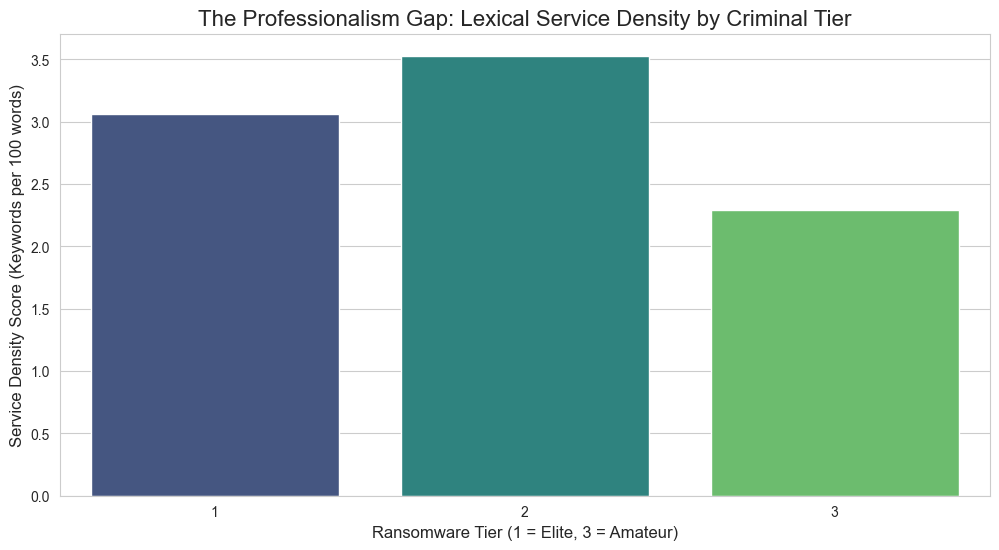

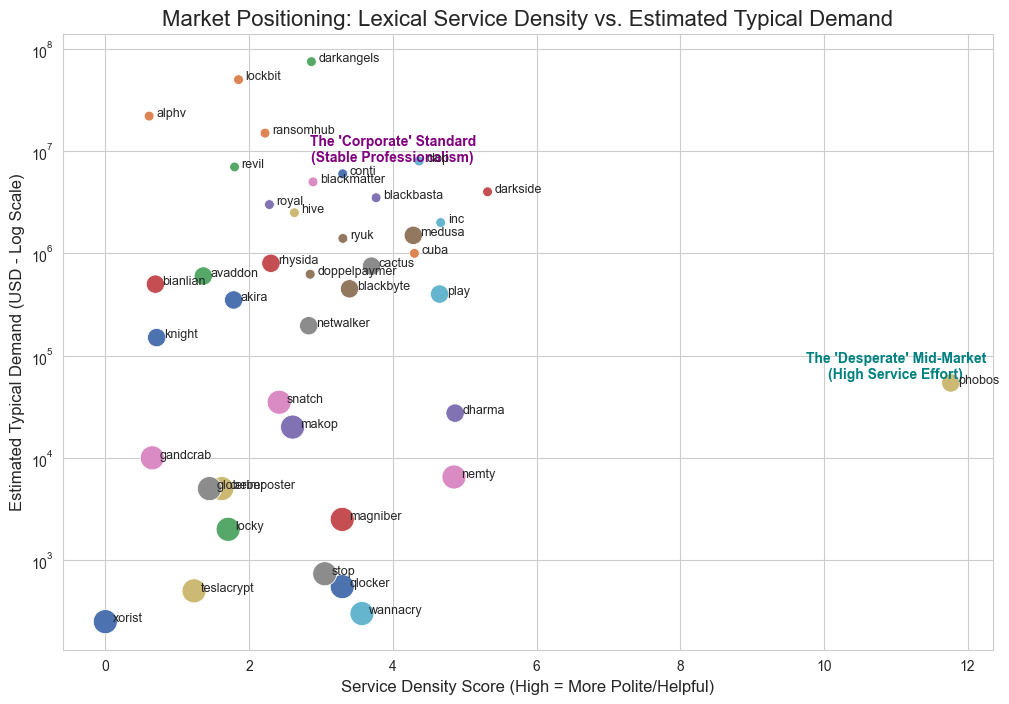

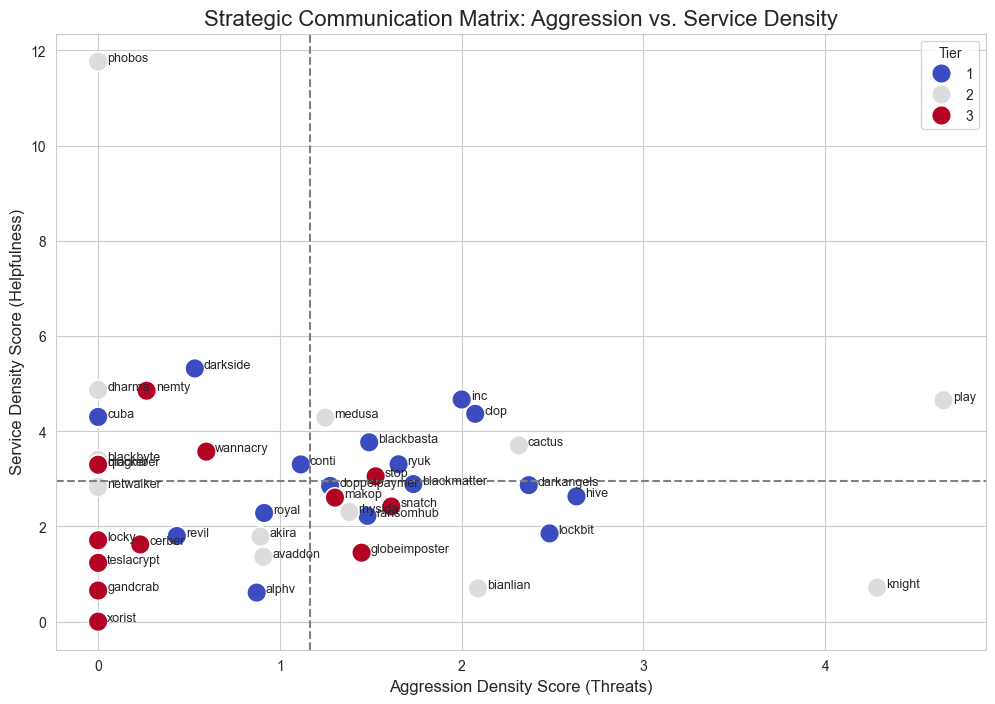

In [9]:
# --- CHART 1: The "Professionalism Gap" (Bar Chart) ---
plt.figure(figsize=(12, 6))
sns.barplot(data=df_merged, x='Tier', y='Service_Score', palette='viridis', errorbar=None)
plt.title('The Professionalism Gap: Lexical Service Density by Criminal Tier', fontsize=16)
plt.xlabel('Ransomware Tier (1 = Elite, 3 = Amateur)', fontsize=12)
plt.ylabel('Service Density Score (Keywords per 100 words)', fontsize=12)
plt.show()

# --- CHART 2: The "Signal Effectiveness" (Scatter Plot) ---
plt.figure(figsize=(12, 8))

# 2A. Main Scatter
scatter = sns.scatterplot(
    data=df_merged, 
    x='Service_Score', 
    y='Average_Demand_USD', 
    size='Tier', 
    hue='Group',
    sizes=(50, 300), 
    palette='deep',
    legend=False
)

# 2B. Add "Zone Annotations"
plt.text(11, 60000, "The 'Desperate' Mid-Market\n(High Service Effort)", 
         fontsize=10, color='teal', ha='center', fontweight='bold')
plt.text(4, 8000000, "The 'Corporate' Standard\n(Stable Professionalism)", 
         fontsize=10, color='purple', ha='center', fontweight='bold')

# Add labels to points
for i in range(df_merged.shape[0]):
    plt.text(
        df_merged.Service_Score[i]+0.1, 
        df_merged.Average_Demand_USD[i], 
        df_merged.Group[i], 
        fontsize=9
    )

plt.yscale('log') # Log scale
plt.title('Market Positioning: Lexical Service Density vs. Estimated Typical Demand', fontsize=16)
plt.xlabel('Service Density Score (High = More Polite/Helpful)', fontsize=12)
plt.ylabel('Estimated Typical Demand (USD - Log Scale)', fontsize=12)
plt.show()

# --- CHART 3: The "Strategy Matrix" (Aggression vs Service) ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_merged, 
    x='Aggression_Score', 
    y='Service_Score', 
    hue='Tier', 
    palette='coolwarm', 
    s=200
)

# Add labels
for i in range(df_merged.shape[0]):
    plt.text(
        df_merged.Aggression_Score[i]+0.05, 
        df_merged.Service_Score[i], 
        df_merged.Group[i], 
        fontsize=9
    )
    
plt.axhline(y=df_merged['Service_Score'].mean(), color='gray', linestyle='--')
plt.axvline(x=df_merged['Aggression_Score'].mean(), color='gray', linestyle='--')
plt.title('Strategic Communication Matrix: Aggression vs. Service Density', fontsize=16)
plt.xlabel('Aggression Density Score (Threats)', fontsize=12)
plt.ylabel('Service Density Score (Helpfulness)', fontsize=12)
plt.show()


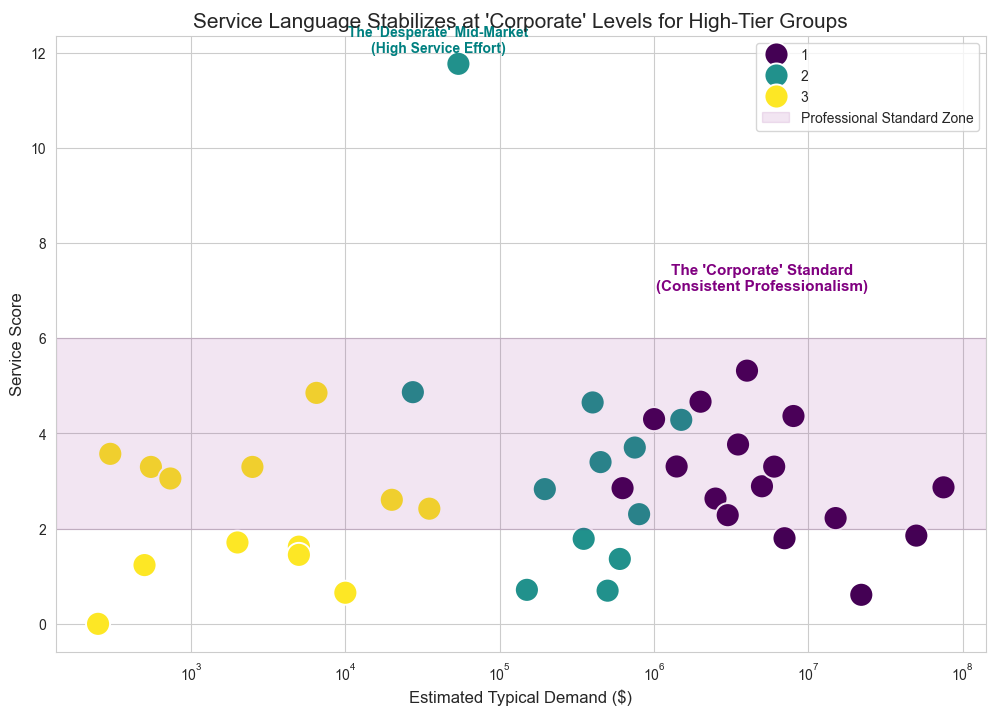


Final Data Table (Sorted by Service Score):


,Group,Tier,Service_Score,Average_Demand_USD
28,phobos,2,11.764706,54000
13,darkside,1,5.319149,4000000
14,dharma,2,4.867257,27375
26,nemty,3,4.852023,6500
19,inc,1,4.666667,2000000
29,play,2,4.651163,400000
9,clop,1,4.366160,8000000
11,cuba,1,4.301075,1000000
25,medusa,2,4.285714,1500000
4,blackbasta,1,3.767980,3500000


In [10]:
# --- FINAL NARRATIVE CHART: Stabilization of Service Language ---
plt.figure(figsize=(12, 8))

# 1. Plot the dots
sns.scatterplot(data=df_merged, x='Average_Demand_USD', y='Service_Score', hue='Tier', s=300, palette='viridis')
plt.xscale('log')

# 2. Add "Zone Boxes"
plt.text(40000, 12, "\nThe 'Desperate' Mid-Market\n(High Service Effort)", 
         fontsize=10, color='teal', ha='center', fontweight='bold')

plt.text(5000000, 7, "The 'Corporate' Standard\n(Consistent Professionalism)", 
         fontsize=11, color='purple', ha='center', fontweight='bold')

# 3. Add shaded region for the "Professional Zone"
plt.axhspan(2, 6, color='purple', alpha=0.1, label='Professional Standard Zone')

plt.title("Service Language Stabilizes at 'Corporate' Levels for High-Tier Groups", fontsize=15)
plt.xlabel("Estimated Typical Demand ($)", fontsize=12)
plt.ylabel("Service Score", fontsize=12)
plt.legend(loc='upper right')

plt.show()

# Print Final Data Table
print("\nFinal Data Table (Sorted by Service Score):")
display(df_merged[['Group', 'Tier', 'Service_Score', 'Average_Demand_USD']].sort_values(by='Service_Score', ascending=False))
